In [3]:
import pandas as pd
import re
import textCleaning as tc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [4]:
df = pd.read_csv("data/tiktok_comments_with_sentiment.csv")
df

,text,createTime,sentiment_score,sentiment_label
0,gibran:,1764933105,-0.014373,neutral
1,ini emg harusnya ganti rakyat sih. bgnian emg ...,1764928295,0.994941,positive
2,wapres aja gak pakek rompi anti peluru,1764922201,0.035081,neutral
3,di indo doang presiden n wapres di hujat wkwk,1764925978,-0.009545,neutral
4,"di X parah bett anjir komenannya, merinding la...",1764922173,0.785454,positive
...,...,...,...,...
4364,"mas wapres panen pahala dari para hatter,\r\ns...",1764985669,0.994848,positive
4365,WOY TERMUL INFO LOKER DONG JADI TERMUL\r\nMAYA...,1764985616,-0.871589,negative
4366,"(wajah, memelas, kasihan, mata, memohon)",1764985466,0.656141,positive
4367,"(jempol, ke, atas, +1, badan, tangan, tubuh) ...",1764985270,0.175705,neutral


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4369 entries, 0 to 4368
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   text             4369 non-null   object 
 1   createTime       4369 non-null   int64  
 2   sentiment_score  4369 non-null   float64
 3   sentiment_label  4369 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 136.7+ KB


In [6]:
df.dropna(inplace=True, subset=['text', 'createTime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4369 entries, 0 to 4368
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   text             4369 non-null   object 
 1   createTime       4369 non-null   int64  
 2   sentiment_score  4369 non-null   float64
 3   sentiment_label  4369 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 136.7+ KB


#### WordCloud

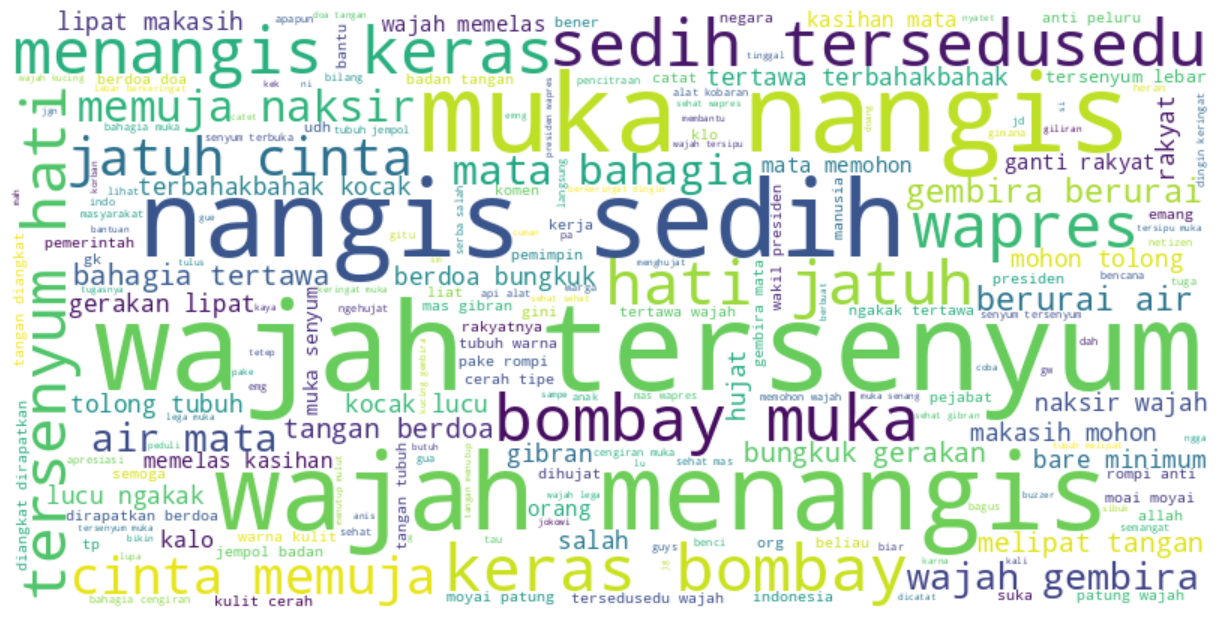

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def clean_text_for_indobert(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\.\S+', '', text)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s.,!?]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

cleanedTxt = df['text'].apply(clean_text_for_indobert)
wordcloudtxt = cleanedTxt.apply(tc.tokenizingText).apply(tc.filteringText)
    
# Convert list of tokens back to string
wordcloud_text = ' '.join(wordcloudtxt.apply(lambda x: ' '.join(x)))

# Create wordcloud from cleaned text
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wordcloud_text)

# Display wordcloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

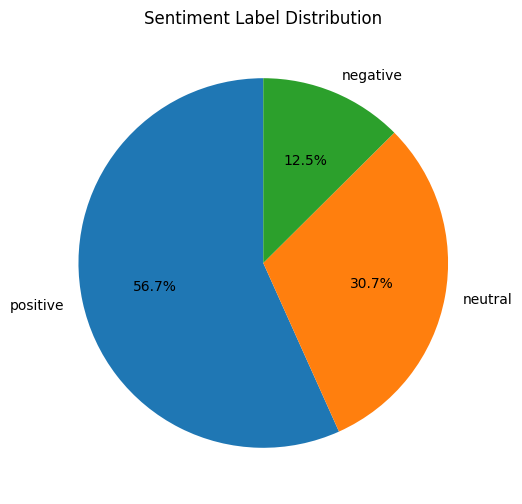

In [8]:
# Count sentiment labels
sentiment_counts = df['sentiment_label'].value_counts()

# Create pie chart
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Sentiment Label Distribution")
plt.show()

In [9]:
x = pd.to_datetime(df['createTime'], unit='s')

df_regression = pd.DataFrame()
start_time = x.min()

df_regression['x'] = (x - start_time).dt.total_seconds() / 3600
df_regression['y'] = df['sentiment_score']


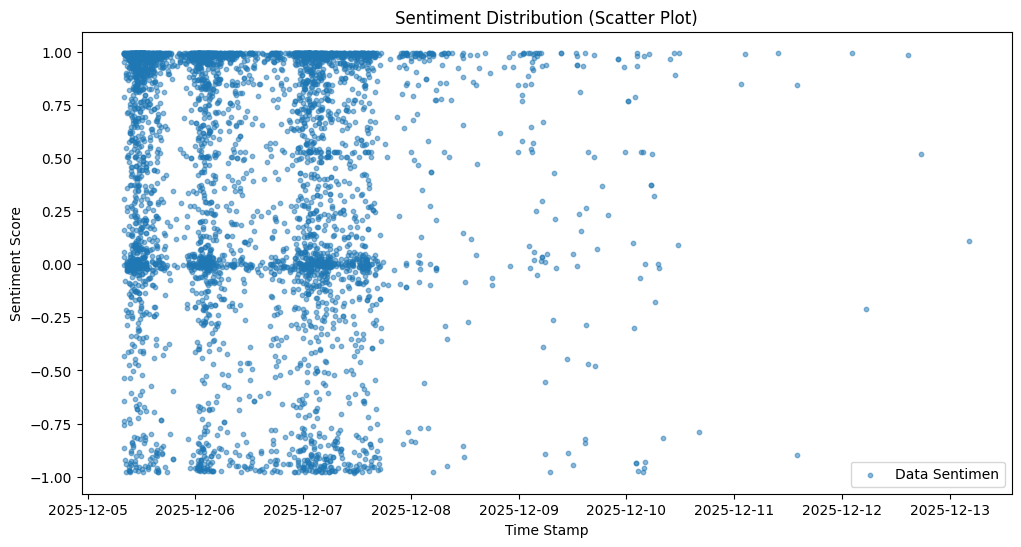

In [10]:
# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(x, df['sentiment_score'], alpha=0.5, s=10, label='Data Sentimen')
plt.title("Sentiment Distribution (Scatter Plot)")
plt.xlabel("Time Stamp" )
plt.ylabel("Sentiment Score")
plt.legend()
plt.show()

MSE Model Linear (Kaku): 0.3748038972877983


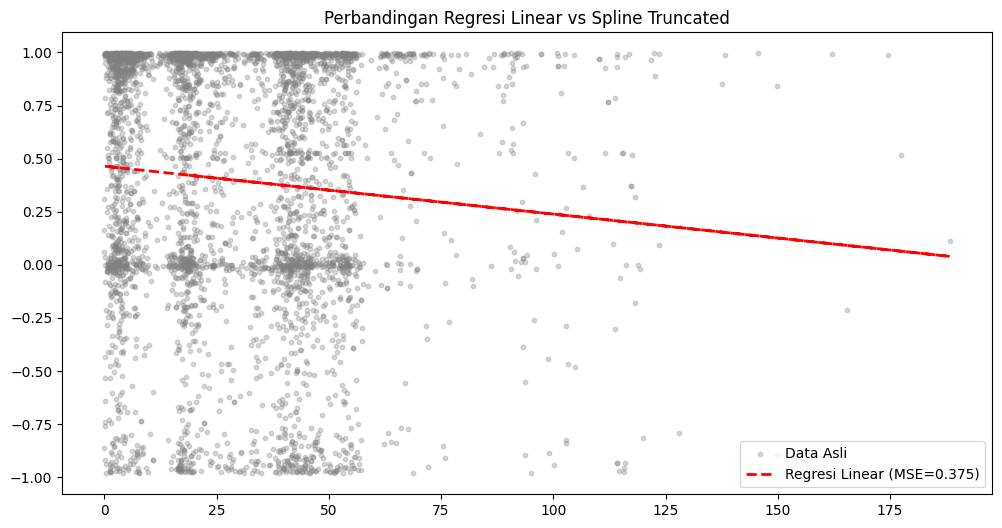

In [11]:
x = df_regression['x'].values
y = df_regression['y'].values
coeffs_linear = np.polyfit(x, y, 1) 
y_linear = np.polyval(coeffs_linear, x)

mse_linear = mean_squared_error(y, y_linear)


print(f"MSE Model Linear (Kaku): {mse_linear}")

plt.figure(figsize=(12, 6))
plt.scatter(x, y, color='gray', alpha=0.3, s=10, label='Data Asli')
plt.plot(x, y_linear, color='red', linestyle='--', linewidth=2, label=f'Regresi Linear (MSE={mse_linear:.3f})')
plt.legend()
plt.title("Perbandingan Regresi Linear vs Spline Truncated")
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_26424\690754194.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('6H')['sentiment_score']


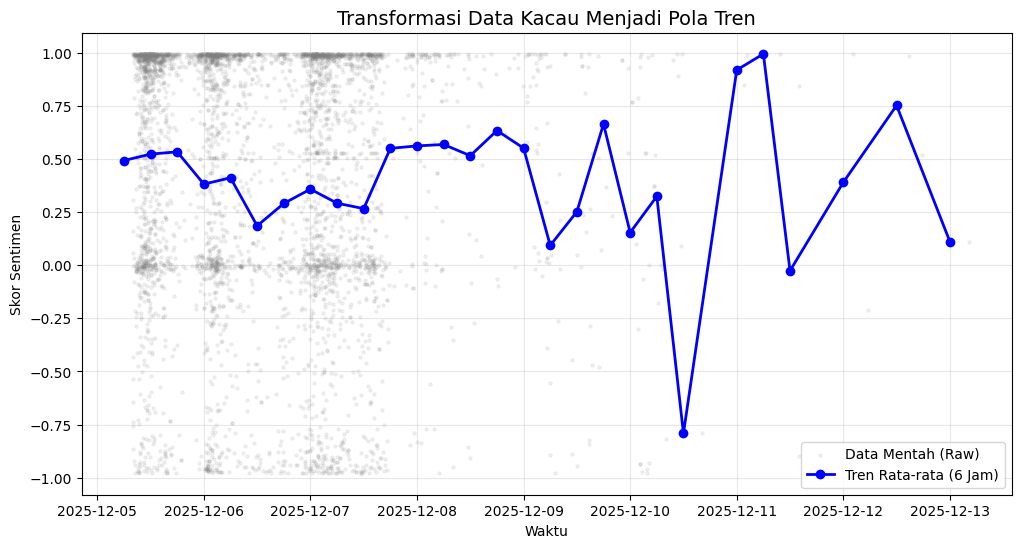

In [12]:
# 1. Gunakan df yang sudah ada dari sel sebelumnya

# 2. Convert Kolom Waktu (createTime) ke Format DateTime
# Asumsi createTime adalah timestamp UNIX. Kalau bukan, sesuaikan.
df['datetime'] = pd.to_datetime(df['createTime'], unit='s')

# 3. Lakukan RESAMPLING (Pengelompokan) hanya pada kolom numerik yang relevan
# Kita hitung rata-rata sentimen setiap 6 jam ('6H')
df_resampled = (
	df.set_index('datetime')
	  .resample('6H')['sentiment_score']
	  .mean()
	  .reset_index()
)

# Hapus data kosong (misal jam 3 pagi gak ada yg komen)
df_resampled = df_resampled.dropna(subset=['sentiment_score'])

# 4. Visualisasi Data yang Sudah "Dihaluskan"
plt.figure(figsize=(12, 6))

# Plot Data Asli (Titik Kecil Transparan) - Biar dosen tau aslinya kacau
plt.scatter(df['datetime'], df['sentiment_score'], alpha=0.1, color='gray', s=5, label='Data Mentah (Raw)')

# Plot Data Rata-rata (Garis Tegas) - Ini POLA yang dicari Spline nanti
plt.plot(df_resampled['datetime'], df_resampled['sentiment_score'], color='blue', linewidth=2, marker='o', label='Tren Rata-rata (6 Jam)')

plt.title('Transformasi Data Kacau Menjadi Pola Tren', fontsize=14)
plt.xlabel('Waktu')
plt.ylabel('Skor Sentimen')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Simpan data yang sudah rapi ini buat dihitung pakai Spline
df_resampled.to_csv("data_siap_spline_bersih.csv", index=False)

In [13]:
# 1. Load Data Bersih Kamu
df = pd.read_csv("data_siap_spline_bersih.csv")

# Kita ubah datetime jadi angka urutan (0, 1, 2, 3...) biar bisa dihitung
# Ini disebut "Time Index"
df['time_idx'] = np.arange(len(df))

X = df[['time_idx']].values
y = df['sentiment_score'].values

# 2. Siapkan Wadah Pencatat Skor
best_mse = float('inf') # Set error awal ke Infinity (tak terbatas)
best_knot = None
best_model = None

# 3. LOOPING: Coba pasang Knot di setiap titik waktu (mulai indeks 5 sampai akhir - 5)
# Kita hindari ujung paling awal dan akhir biar gak error
potential_knots = df['time_idx'].values[5:-5]

print("Sedang mencari Knot terbaik...")

for k in potential_knots:
    # --- PROSES MATEMATIKA ---
    # a. Buat fitur Truncated (x - k)+
    X_truncated = np.maximum(0, X - k)
    
    # b. Gabung X dan Truncated
    X_combined = np.hstack([X, X_truncated])
    
    # c. Hitung Model (Cari Beta)
    model = LinearRegression()
    model.fit(X_combined, y)
    y_pred = model.predict(X_combined)
    
    # d. Hitung Error (MSE)
    mse = mean_squared_error(y, y_pred)
    
    # --- BANDINGKAN SKOR ---
    # Kalau error sekarang lebih kecil dari rekor sebelumnya, simpan!
    if mse < best_mse:
        best_mse = mse
        best_knot = k
        best_model = model

# 4. UMUMKAN PEMENANG
# Kembalikan time_idx ke jam asli biar manusia paham
waktu_knot_asli = df.iloc[best_knot]['datetime']

print(f"\n=== KNOT OPTIMAL DITEMUKAN! ===")
print(f"Posisi Index Knot : {best_knot}")
print(f"Waktu Kejadian    : {waktu_knot_asli}")
print(f"Minimum MSE       : {best_mse}")


Sedang mencari Knot terbaik...

=== KNOT OPTIMAL DITEMUKAN! ===
Posisi Index Knot : 21
Waktu Kejadian    : 2025-12-10 12:00:00
Minimum MSE       : 0.10418335438504715


--- Mencari Jumlah Knot Terbaik ---
Knot Terbaik Ditemukan: 9 knot
Lokasi Knot: [1. 2. 3. 4. 5. 6. 7. 8. 9.]
MSE Linear: 0.6444
MSE Spline: 0.1785 (Lebih kecil = Lebih bagus)



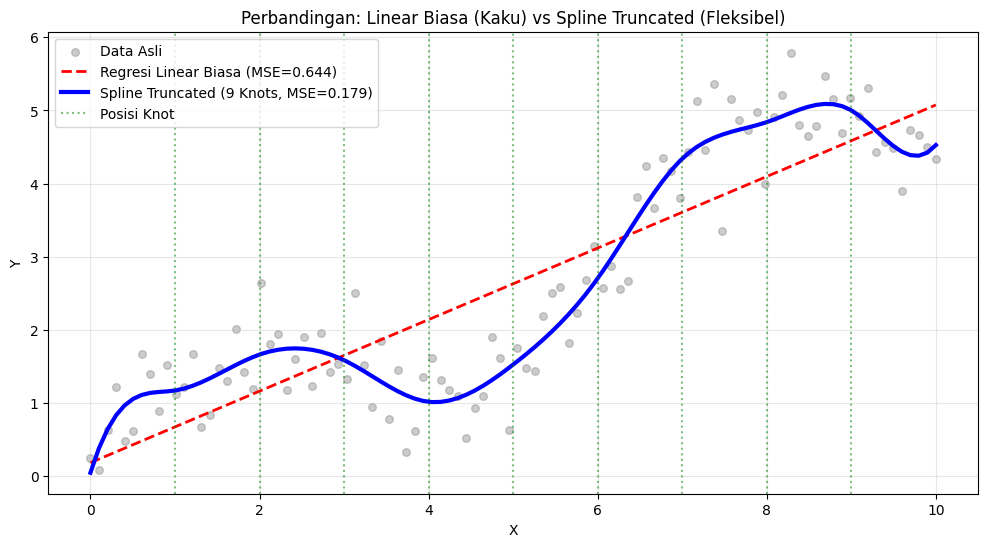

In [14]:
# --- BAGIAN 1: PERSIAPAN DATA (DUMMY) ---
# Kita buat data pura-pura yang bergelombang agar terlihat bedanya
np.random.seed(42)
n = 100
x_dummy = np.linspace(0, 10, n)
# Rumus: Sinus + Sedikit naik ke atas + Noise acak
y_dummy = np.sin(x_dummy) + 0.5 * x_dummy + np.random.normal(0, 0.5, n)

# Masukkan ke DataFrame (seolah-olah ini df_regression Anda)
df_regression = pd.DataFrame({'x': x_dummy, 'y': y_dummy})

# Ambil values sesuai request Anda
x = df_regression['x'].values
y = df_regression['y'].values

# --- BAGIAN 2: MODEL LINEAR BIASA (KODE ANDA) ---
# Ini model yang "Kaku" (Hanya garis lurus)
coeffs_linear = np.polyfit(x, y, 1) 
y_linear = np.polyval(coeffs_linear, x)
mse_linear = mean_squared_error(y, y_linear)

# --- BAGIAN 3: MODEL SPLINE TRUNCATED (MENCARI KNOT TERBAIK) ---

# Fungsi untuk membuat kolom-kolom baru sesuai rumus Truncated Power Basis
def create_spline_features(x, knots, p=3):
    # 1. Buat kolom dasar: x, x^2, x^3
    # Kita pakai p=3 untuk Cubic Spline
    X_matrix = np.vstack([x**i for i in range(1, p+1)]).T
    
    # 2. Buat kolom tambahan untuk setiap knot (rumus (x - xi)^3+)
    for k in knots:
        # np.maximum(0, ...) adalah fungsi "saklar" (truncated)
        # Jika (x-k) negatif, dia jadi 0. Jika positif, dia dipangkatkan 3.
        knot_col = np.maximum(0, (x - k))**p
        X_matrix = np.column_stack([X_matrix, knot_col])
        
    return X_matrix

# Logika Otomatis Mencari Knot Terbaik
best_mse = float('inf')
best_knots = []
best_y_pred = None
best_model = None

# Kita coba jumlah knot dari 1 sampai 10
print("--- Mencari Jumlah Knot Terbaik ---")
for n_knots in range(1, 11):
    # Tentukan posisi knot secara merata (equidistant)
    # (Mulai sedikit setelah awal, berhenti sedikit sebelum akhir)
    current_knots = np.linspace(x.min(), x.max(), n_knots + 2)[1:-1]
    
    # Buat fitur/kolom baru (Feature Engineering)
    X_spline = create_spline_features(x, current_knots)
    
    # Lakukan Regresi pada fitur baru tersebut
    model = LinearRegression()
    model.fit(X_spline, y)
    y_pred_spline = model.predict(X_spline)
    
    # Hitung Error
    mse = mean_squared_error(y, y_pred_spline)
    
    # Simpan jika ini yang terbaik
    if mse < best_mse:
        best_mse = mse
        best_knots = current_knots
        best_y_pred = y_pred_spline
        best_model = model

print(f"Knot Terbaik Ditemukan: {len(best_knots)} knot")
print(f"Lokasi Knot: {np.round(best_knots, 2)}")
print(f"MSE Linear: {mse_linear:.4f}")
print(f"MSE Spline: {best_mse:.4f} (Lebih kecil = Lebih bagus)\n")

# --- BAGIAN 4: VISUALISASI PERBANDINGAN ---
plt.figure(figsize=(12, 6))

# 1. Plot Data Asli
plt.scatter(x, y, color='gray', alpha=0.4, s=30, label='Data Asli')

# 2. Plot Regresi Linear Biasa
plt.plot(x, y_linear, color='red', linestyle='--', linewidth=2, 
         label=f'Regresi Linear Biasa (MSE={mse_linear:.3f})')

# 3. Plot Spline Terbaik
# Kita urutkan x dulu supaya garisnya nyambung rapi saat di-plot
sort_idx = np.argsort(x)
plt.plot(x[sort_idx], best_y_pred[sort_idx], color='blue', linewidth=3, 
         label=f'Spline Truncated ({len(best_knots)} Knots, MSE={best_mse:.3f})')

# 4. Gambar Posisi Knot (Garis vertikal tipis)
for k in best_knots:
    plt.axvline(k, color='green', linestyle=':', alpha=0.5, label='Posisi Knot' if k==best_knots[0] else "")

plt.legend()
plt.title("Perbandingan: Linear Biasa (Kaku) vs Spline Truncated (Fleksibel)")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True, alpha=0.3)
plt.show()

MSE Linear: 0.1059
MSE Spline (Cubic, 7 knot): 0.0886
Knot positions (time_idx): [ 3.38  6.75 10.12 13.5  16.88 20.25 23.62]


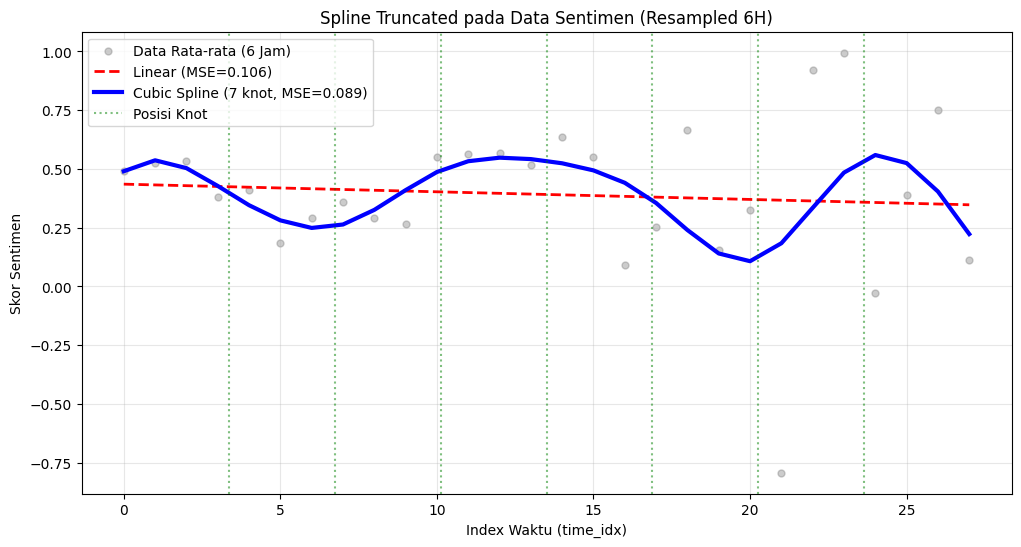

In [15]:
# 1) Load data resampling yang sudah disimpan
_df_spline = pd.read_csv("data_siap_spline_bersih.csv")

# Pastikan kolom datetime ada dan bisa dipakai untuk visualisasi waktu
if 'datetime' in _df_spline.columns:
    try:
        _df_spline['datetime'] = pd.to_datetime(_df_spline['datetime'])
    except Exception:
        pass

# 2) Buat indeks waktu agar bisa dipakai sebagai variabel x
_df_spline['time_idx'] = np.arange(len(_df_spline))

x = _df_spline['time_idx'].values.astype(float)
y = _df_spline['sentiment_score'].values.astype(float)

# 3) Model linear sederhana (pembanding)
coeffs_linear = np.polyfit(x, y, 1)
y_linear = np.polyval(coeffs_linear, x)
mse_linear = mean_squared_error(y, y_linear)

# 4) Fungsi pembuat fitur truncated power basis (cubic spline)
def create_spline_features(x, knots, p=3):
    # Kolom dasar: x, x^2, ..., x^p
    X = np.vstack([x**i for i in range(1, p+1)]).T
    # Kolom truncated untuk tiap knot: (x - k)^p_+
    for k in knots:
        X = np.column_stack([X, np.maximum(0, x - k)**p])
    return X

# 5) Cari jumlah knot terbaik otomatis dengan grid kecil
best_mse = float('inf')
best_knots = []
best_pred = None
best_model = None

max_try_knots = max(1, min(10, len(x)//4))  # batasi jumlah knot agar stabil

for n_knots in range(1, max_try_knots + 1):
    # tempatkan knot merata di domain x (hindari ujung)
    knots = np.linspace(x.min(), x.max(), n_knots + 2)[1:-1]
    X_spline = create_spline_features(x, knots, p=3)

    model = LinearRegression()
    model.fit(X_spline, y)
    y_pred = model.predict(X_spline)

    mse = mean_squared_error(y, y_pred)
    if mse < best_mse:
        best_mse = mse
        best_knots = knots
        best_pred = y_pred
        best_model = model

print(f"MSE Linear: {mse_linear:.4f}")
print(f"MSE Spline (Cubic, {len(best_knots)} knot): {best_mse:.4f}")
print(f"Knot positions (time_idx): {np.round(best_knots, 2)}")

# 6) Visualisasi hasil pada domain indeks waktu
plt.figure(figsize=(12, 6))
plt.scatter(x, y, color='gray', alpha=0.4, s=25, label='Data Rata-rata (6 Jam)')
plt.plot(x, y_linear, color='red', linestyle='--', linewidth=2,
         label=f'Linear (MSE={mse_linear:.3f})')

# urutkan agar garis spline mulus
order = np.argsort(x)
plt.plot(x[order], best_pred[order], color='blue', linewidth=3,
         label=f'Cubic Spline ({len(best_knots)} knot, MSE={best_mse:.3f})')

# garis vertikal posisi knot
for i, k in enumerate(best_knots):
    plt.axvline(k, color='green', linestyle=':', alpha=0.5,
                label='Posisi Knot' if i == 0 else '')

plt.title('Spline Truncated pada Data Sentimen (Resampled 6H)')
plt.xlabel('Index Waktu (time_idx)')
plt.ylabel('Skor Sentimen')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()